# Working Examples of spectrums

The following notebook illustrate several aspects we want from spectrum estimators.

## Getting tools ready 

Run the following cells to get the analysis ready,
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,5)

In [2]:
def get_time_vect(t_end, sampl_freq):
    """Return a time vector
    
    Parameters:
    -----------
    t_end : duration in seconds    
    sampl_freq : sampling frequency in Hertz
    
    Output:
    -------
    time_vect : np_array of times in seconds
    """
    nsample =int(t_end*sampl_freq)
    time_vect = np.linspace(0,t_end,nsample)
    return time_vect

In [3]:
def get_sine(
        time_vector, 
        amplitude, 
        frequency) :
    """Creates a sine signal
    
    Parameters:
    -----------
    time_vector : np_array of times in seconds
    amplitude : float, sine amplitude
    frequency : float, heartz, frequency of sine
    
    Output:
    -------
    signal_vector : np_array of values
    
    """
    signal_vector = amplitude*np.sin(time_vector*2*np.pi*frequency)
    return signal_vector

In [4]:
def get_noise(
        time_vector,
        noise_amp,
        pink=False) :
    """Creates a noise signal
    
    Parameters:
    -----------
    time_vector : np_array of times in seconds
    amplitude : float, sine amplitude
    
    Output:
    -------
    signal_vector : np_array of values
    
    """
    noise = (np.random.random(len(time_vector))*2-1)
    noise *= noise_amp
    
    if pink:
        ff_noise = np.fft.fft(noise)
        freqn = np.linspace(1, noise.shape[0], noise.shape[0])
        ff_noise /= freqn
        ff_noise /= freqn
        noise = np.fft.ifft(ff_noise)
        noise -= noise.mean()
        
    
    return noise

In [5]:
# Define the calculation parameters according to spectral analysis theory.
def fourier_transform(time_vect, signal_vect, zero_pad=0) :
    """This function automates the creation of the Fourier Transform of a signal."""
    
    total_time = time_vect[-1] - time_vect[0]
    dt = time_vect[1] - time_vect[0]
    freq_resolution = 1. / total_time
    freq_nyquist = 1. / dt

    
    zeros = np.ones_like(signal_vect)*signal_vect.mean()
    for pad in range(zero_pad):
        signal_vect = np.append(signal_vect, zeros)
    time_vect = get_time_vect(time_vect[-1]*(1+zero_pad), freq_nyquist)   
    
    
    freq_nyquist /= (1+zero_pad)
    freq_resolution /= (1+zero_pad)
    
    all_freq = np.arange(0, freq_nyquist, freq_resolution ,dtype=np.float) 
    N = len(all_freq)
    freq = all_freq[0:int(N/2) - 1]

    raw_fft = np.fft.fft(signal_vect)
    amplitude_spectrum = np.absolute(raw_fft)[0:int(N/2) - 1]
    amplitude_spectrum /= N
    amplitude_spectrum[1:] *= 2
    
    power_spectral_density = np.square(amplitude_spectrum)/freq_resolution
    power_spectral_density[1:] *= 0.5 / (1+zero_pad)
    
    cumulate = np.cumsum(power_spectral_density)*freq_resolution
    return freq, amplitude_spectrum, power_spectral_density, cumulate

In [6]:
def make_plots(data1, data2=None, data3=None):
    ax1 = plt.subplot(141, title="signal")
    ax1.grid(True)
    ax2 = plt.subplot(142, title="Amplitude")
    ax2.grid(True, which='both')
    #ax2.set_ylim(bottom=0.1, top=10)
    ax3 = plt.subplot(143, title="Power  Spectral density")
    ax3.grid(True, which='both')
    #ax3.set_ylim(bottom=0.1, top=10000)
    ax4 = plt.subplot(144, title="Cumulate PSD")
    ax4.grid(True, which='both')
    
    #data1
    ax1.plot(data1["time"], data1["signal"], "o-k")
    ax2.loglog(data1["freq"], data1["ampl"], "o-k")
    ax3.loglog(data1["freq"], data1["dsp"] , "o-k")
    ax4.semilogx(data1["freq"], data1["cumul"], "o-k")
    
    #data2
    if data2 is not None:
        ax1.plot(data2["time"], data2["signal"], "o-b")
        ax2.loglog(data2["freq"], data2["ampl"], "o-b")
        ax3.loglog(data2["freq"], data2["dsp"] , "o-b")
        ax4.semilogx(data2["freq"], data2["cumul"], "o-b")
    
    #data3
    if data2 is not None:
        ax1.plot(data3["time"], data3["signal"], "o-c")
        ax2.loglog(data3["freq"], data3["ampl"], "o-c")
        ax3.loglog(data3["freq"], data3["dsp"] , "o-c")
        ax4.semilogx(data3["freq"], data3["cumul"], "o-c")
    

In [7]:


def analysis(t_end=1.e-3, f_sam =50000., amp=10., noise_amp=1., freq=4000, zero_pad=0, realisation=10):
    
    

    out = dict()
    time = get_time_vect(t_end, f_sam)
    sine = get_sine(time, amp, freq)
    noise = get_noise(time, noise_amp)
    signal = sine + noise
    
    freqencies, amplitude_spectrum, dsp_spectrum, cumulate_dsp = fourier_transform(time, signal, zero_pad=zero_pad)
    out["signal"] = signal / realisation
    out["ampl"] = amplitude_spectrum/ realisation
    out["dsp"] = dsp_spectrum/ realisation
    out["cumul"] = cumulate_dsp/ realisation
    out["time"] = time
    out["freq"] = freqencies

    for _ in range(realisation):
        sine = get_sine(time, amp, freq)
        noise = get_noise(time, noise_amp)
        signal = sine + noise
        freqencies, amplitude_spectrum, dsp_spectrum, cumulate_dsp = fourier_transform(time, signal, zero_pad=zero_pad)
   
        out["signal"] += signal / realisation
        out["ampl"] += amplitude_spectrum/ realisation
        out["dsp"] += dsp_spectrum/ realisation
        out["cumul"] += cumulate_dsp/ realisation
    return out

# Signal length variation

The signal lenght should not affect the peaks in the amplitude, neither the broadband noiseion the DSP, neither the cumulate!


/var/folders/1y/mx3dx_f11f1cmf6mc0l79mdh000362/T/ipykernel_2222/1203597304.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_freq = np.arange(0, freq_nyquist, freq_resolution ,dtype=np.float)


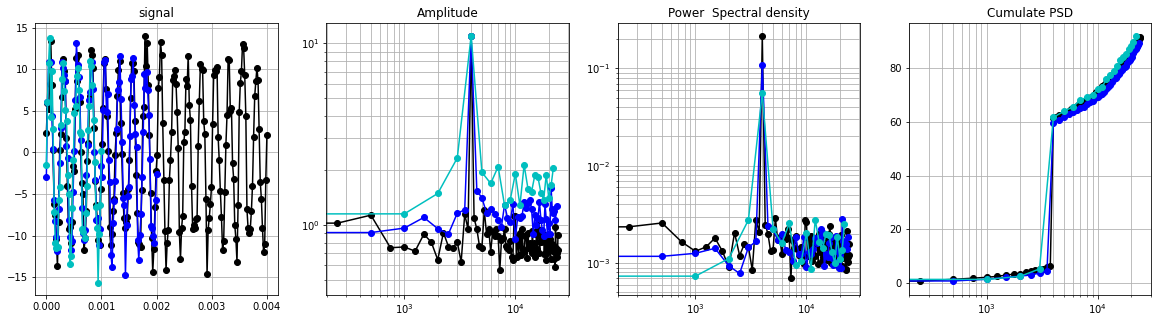

In [9]:
def test_length(tend_list):
    out1 = analysis(t_end=tend_list[0], noise_amp=10.)
    out2 = analysis(t_end=tend_list[1], noise_amp=10.)
    out3 = analysis(t_end=tend_list[2], noise_amp=10.)
    
    make_plots(out1, data2=out2, data3=out3)

test_length([0.004, 0.002, 0.001])

# Amplitude variation

Amplitude should NOT affect PSD broadband estimation...

/var/folders/1y/mx3dx_f11f1cmf6mc0l79mdh000362/T/ipykernel_2222/1203597304.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_freq = np.arange(0, freq_nyquist, freq_resolution ,dtype=np.float)


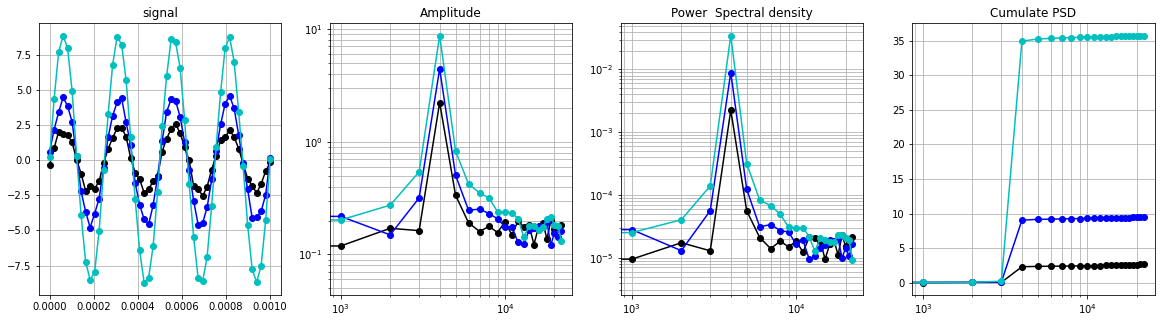

In [10]:
def test_amp(in_list):
    out1 = analysis(amp=in_list[0])
    out2 = analysis(amp=in_list[1])
    out3 = analysis(amp=in_list[2])
    
    make_plots(out1, data2=out2, data3=out3)

test_amp([2., 4., 8])

# Noise variation

Noise should NOT affect amplitude peaks!

/var/folders/1y/mx3dx_f11f1cmf6mc0l79mdh000362/T/ipykernel_2222/1203597304.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_freq = np.arange(0, freq_nyquist, freq_resolution ,dtype=np.float)


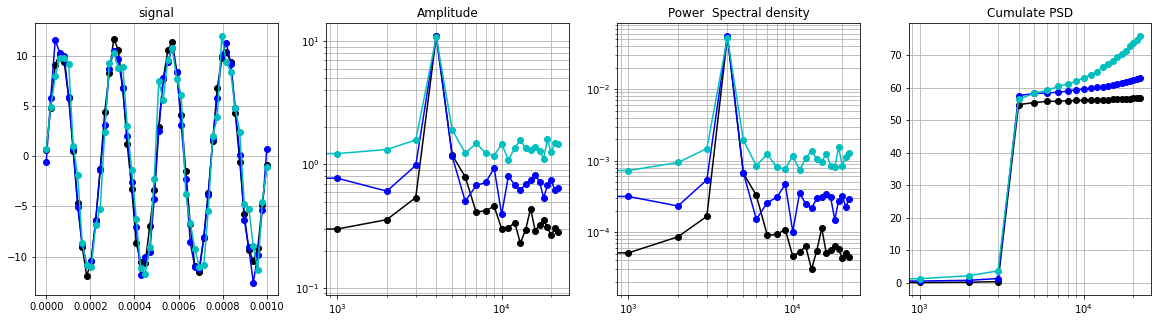

In [11]:
def test_noise_amp(in_list):
    out1 = analysis(noise_amp=in_list[0])
    out2 = analysis(noise_amp=in_list[1])
    out3 = analysis(noise_amp=in_list[2])
    
    make_plots(out1, data2=out2, data3=out3)

test_noise_amp([2., 4., 8])

# Signal sampling variation

Signal sampling is affecting only the righ bound of the spectrum (unless aliasing is done)

/var/folders/1y/mx3dx_f11f1cmf6mc0l79mdh000362/T/ipykernel_2222/1203597304.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_freq = np.arange(0, freq_nyquist, freq_resolution ,dtype=np.float)


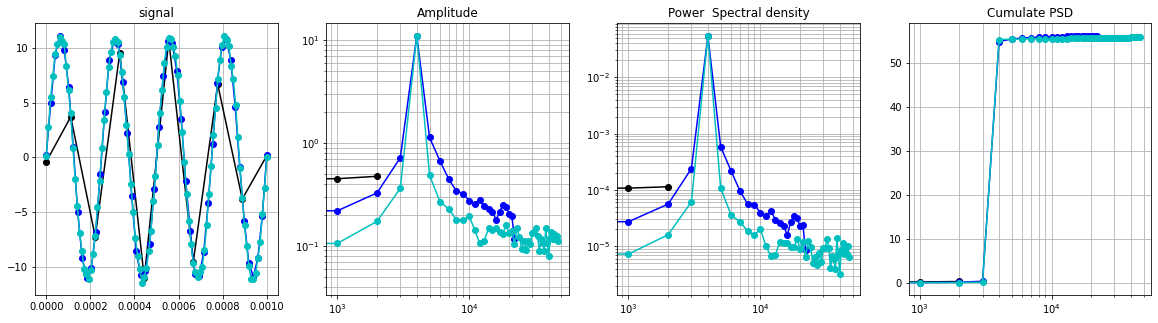

In [12]:
def test_sampling_freq(in_list):
    out1 = analysis(f_sam=in_list[0])
    out2 = analysis(f_sam=in_list[1])
    out3 = analysis(f_sam=in_list[2])
    
    make_plots(out1, data2=out2, data3=out3)

test_sampling_freq([10000., 50000., 100000])

# Zero padding

adding zero padding should NOT affect any of the estimators

/var/folders/1y/mx3dx_f11f1cmf6mc0l79mdh000362/T/ipykernel_2222/1203597304.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_freq = np.arange(0, freq_nyquist, freq_resolution ,dtype=np.float)


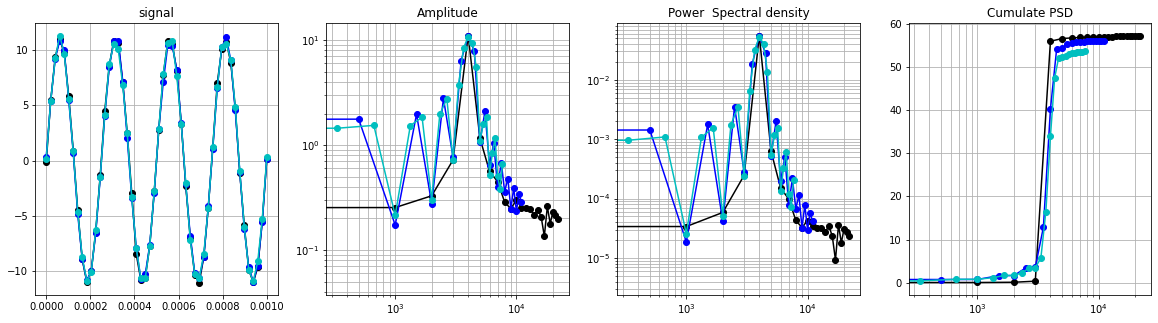

In [13]:
def test_zero_pad(in_list):
    out1 = analysis(zero_pad=in_list[0])
    out2 = analysis(zero_pad=in_list[1])
    out3 = analysis(zero_pad=in_list[2])
    
    make_plots(out1, data2=out2, data3=out3)

test_zero_pad([0, 1, 2])